# Time dependence

### Motivation: THE ranking is updated every year. It is likely that the database has significant time dependence. One aspect is that new Universities can appear (or disappear). Another aspect is that more and more Universities are covered by THE ranking. While we will not distinguish between these two mechanisms, it is instructive to analyse how the THE database grows in time (e.g. in terms of the University number or students number). The number of Universities worldwide (which can vary depending on definition) is often estimated to be between 25 000 and 50 000. So it also interesting to check how many of those are covered by THE.   

### 1. Importing libraries and data

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os

plt.style.use('fivethirtyeight') 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [97]:
# Import prepared dataset

path = r'C:/Users/skhra/DataAnalytics/THE_Rating'
df = pd.read_csv(os.path.join(path, '02-Data', 'PreparedData', 'THE_prepared.csv'))

In [98]:
df.shape

(14522, 14)

In [99]:
df.head(5)

,Rank,Name,Country,Student Population,Students to Staff Ratio,International Students,Female to Male Ratio,Overall Score,Teaching,Research Environment,Research Quality,Industry Impact,International Outlook,Year
0,1.0,California Institute of Technology,United States,2243.0,6.9,26%,33 : 67,95.2,95.6,97.6,99.8,97.8,64.0,2016
1,2.0,University of Oxford,United Kingdom,19920.0,11.6,34%,46:54:00,94.2,86.5,98.9,98.8,73.1,94.4,2016
2,3.0,Stanford University,United States,15596.0,7.8,22%,42:58:00,93.9,92.5,96.2,99.9,63.3,76.3,2016
3,4.0,University of Cambridge,United Kingdom,18810.0,11.8,34%,46:54:00,92.8,88.2,96.7,97.0,55.0,91.5,2016
4,5.0,Massachusetts Institute of Technology,United States,11074.0,9.0,33%,37 : 63,92.0,89.4,88.6,99.7,95.4,84.0,2016


### 2. Wrangling data

In [100]:
# Keeping only the columns to be used in time analysis
df = df[['Year','Student Population']]

In [101]:
df.head(5)

,Year,Student Population
0,2016,2243.0
1,2016,19920.0
2,2016,15596.0
3,2016,18810.0
4,2016,11074.0


In [102]:
#Group data by year
data = df.groupby('Year').agg(
    university_number=('Year', 'count'),    # Count of rows per year = Number of Universities
    students_number=('Student Population', 'sum') # Sum of students per year
).reset_index()

In [103]:
data

,Year,university_number,students_number
0,2016,800,19257419.0
1,2017,981,24479105.0
2,2018,1103,27237218.0
3,2019,1258,31018575.0
4,2020,1397,33166382.0
5,2021,1526,35277893.0
6,2022,1662,37274098.0
7,2023,1799,40486842.0
8,2024,1904,42254285.0
9,2025,2092,45717550.0


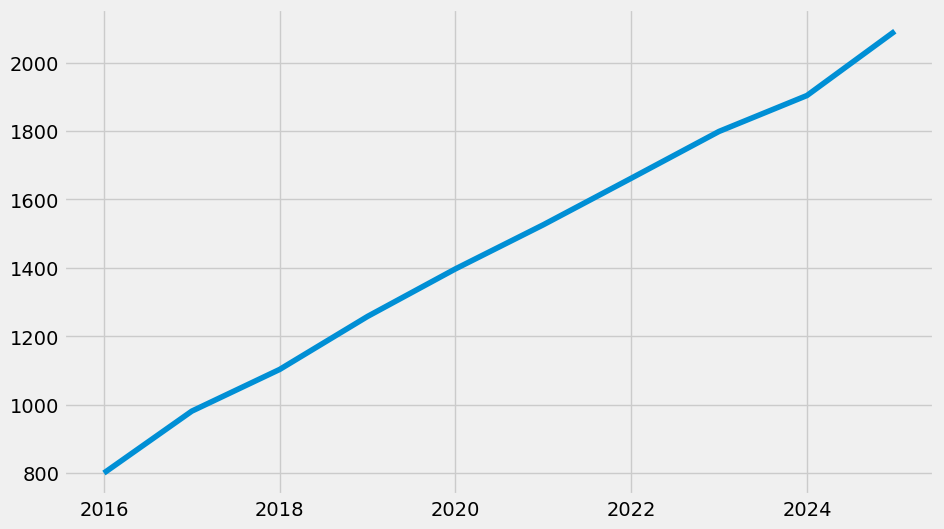

In [104]:
plt.figure(figsize=(10,6), dpi=100)
plt.plot(data['Year'],data['university_number'])

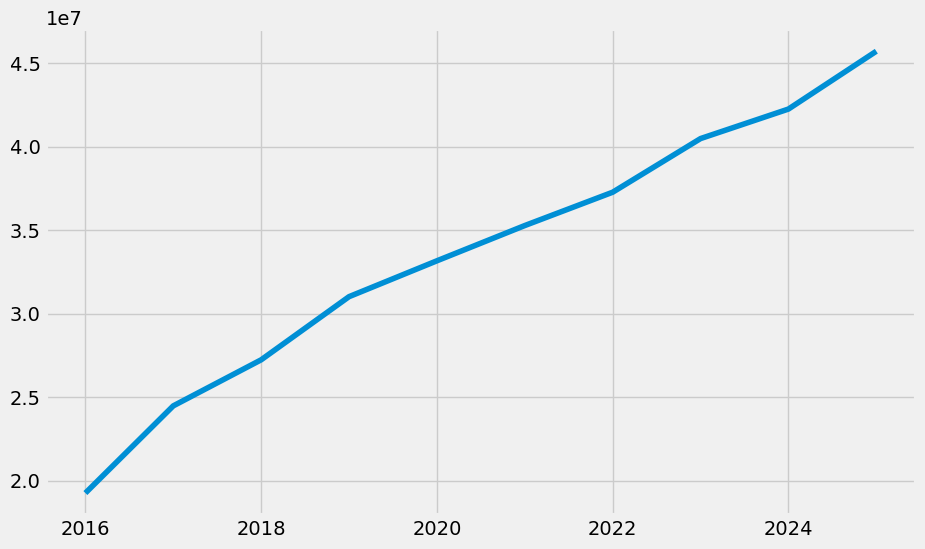

In [105]:
plt.figure(figsize=(10,6), dpi=100)
plt.plot(data['Year'],data['students_number'])

#### There is a clear correlation between the data. The number of students is proportional to the number of universities. This is shown in the figure below

In [125]:
# Performing linear regression analysis

X = data[['university_number']]     # Features (must be 2D)
y = data['students_number']      # Target (1D)
model = LinearRegression()
model.fit(X, y)

LinearRegression()

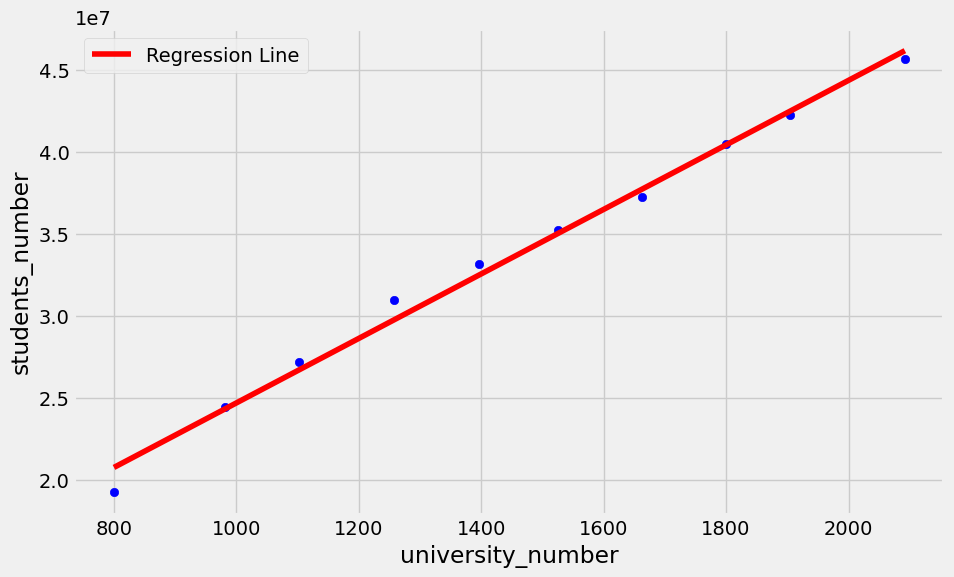

In [107]:
#Plot regression line

plt.figure(figsize=(10,6), dpi=100)
plt.scatter(data['university_number'], data['students_number'], color='blue')
plt.plot(data['university_number'], model.predict(X), color='red', label='Regression Line')
plt.xlabel('university_number')
plt.ylabel('students_number')
plt.legend()
plt.show()

In [108]:
# Model performance
y_pred = model.predict(X)
print("Mean Squared Error:", mean_squared_error(y, y_pred))
print("R-squared:", r2_score(y, y_pred))

Mean Squared Error: 505856522739.584
R-squared: 0.9918634497581365


#### The R^2 coefficient very close to unity indicates excellent performance of the model

#### In the following to keep simplicity we will work only with the university_number data

In [109]:
# Droping not used column
data_2 = data.drop(columns = ['students_number']) 

In [110]:
data_2.dtypes

Year                 int64
university_number    int64
dtype: object

In [111]:
# Set the "Date" column as the index

data_2['Year'] = data_2['Year'].astype(str)
data_2['datetime'] = pd.to_datetime(data_2['Year'], format='%Y', errors='coerce')
data_2.set_index('datetime', inplace=True) # Set datetime as index
# Drop the 'Year' column if it exists
if 'Year' in data_2.columns:
    data_2.drop(['Year'], axis=1, inplace=True)

In [112]:
data_2

,university_number
datetime,
2016-01-01,800
2017-01-01,981
2018-01-01,1103
2019-01-01,1258
2020-01-01,1397
2021-01-01,1526
2022-01-01,1662
2023-01-01,1799
2024-01-01,1904


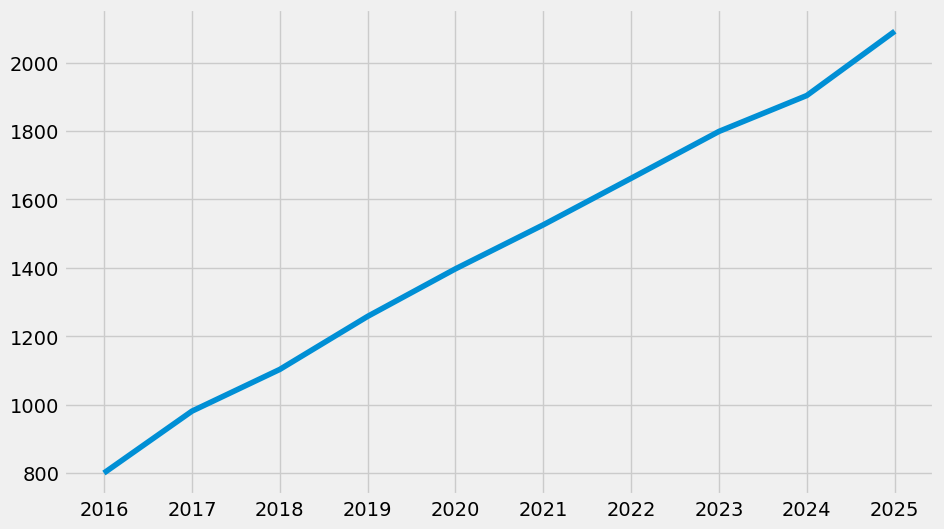

In [113]:
# Plot the new data set

plt.figure(figsize=(10,6), dpi=100)
plt.plot(data_2)

### 3. Time-series analysis: decomposition

In [114]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_2, model='additive')

In [115]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 15, 8

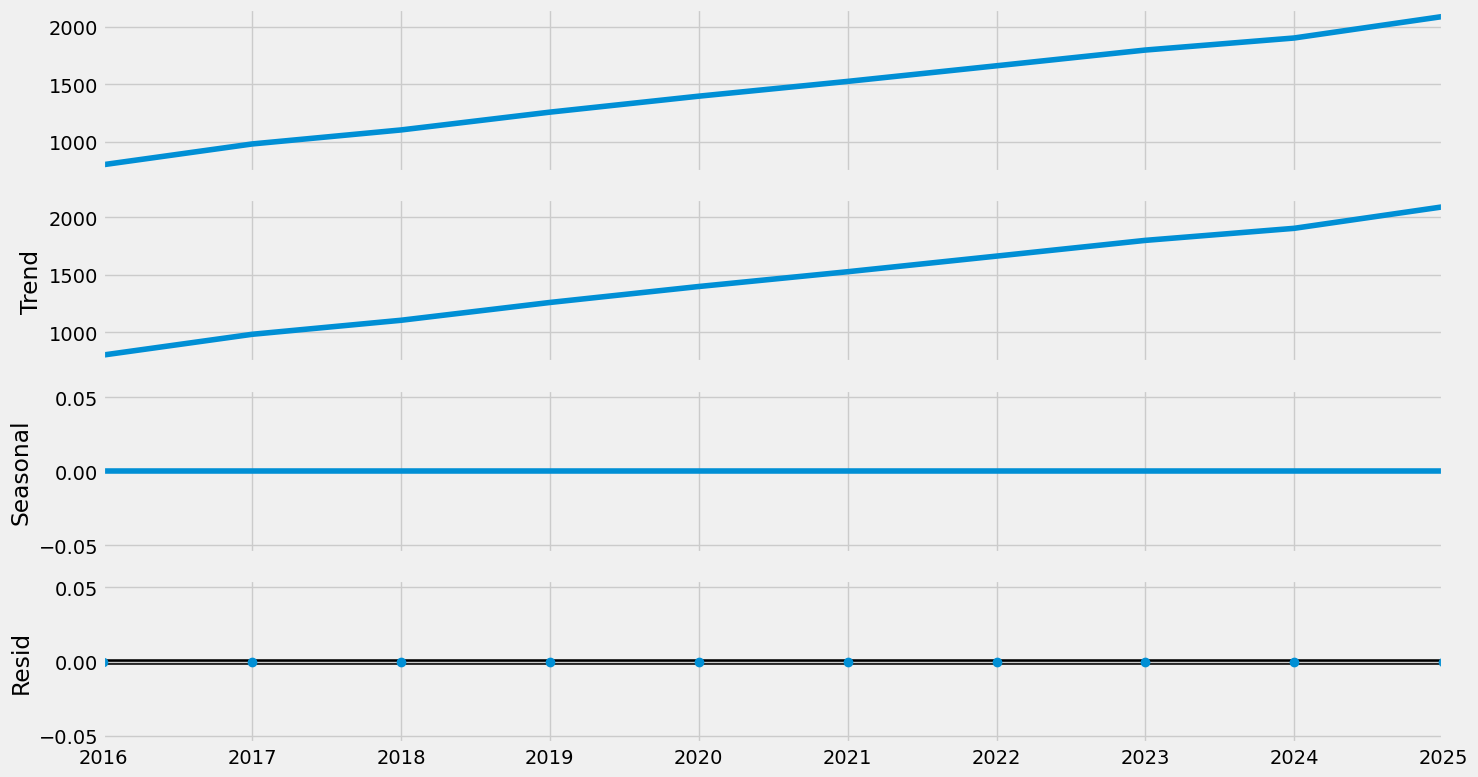

In [116]:
# Plot the separate components

decomposition.plot()
plt.show()

#### The decomposed signal shows only the trend as could be expected. The data are collected on yearly basis, so no seasonal dependence can be present. The data also follow nicely a linear increasing trend so that the noise is quite small. The signal is clearly non-stationary and we'll quantify this below.

### 4. Testing for stationarity

In [117]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_2['university_number'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.748672
p-value                        0.406226
Number of Lags Used            3.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64


#### The test statistics is larger than any of the critical values => can't reject null hypothesis => the data is non-stationary (but this was obvious from the beginning)

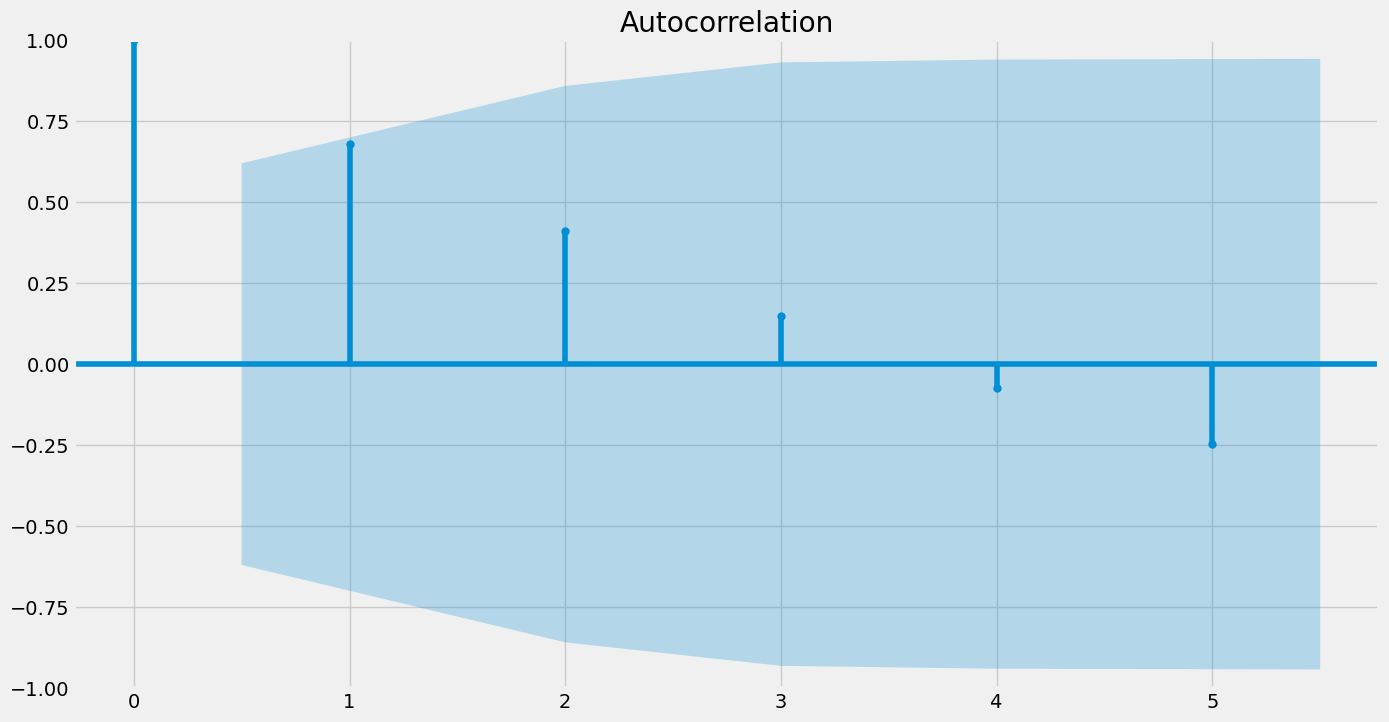

In [118]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_2)
plt.show()

### 5. Stationarizing the dataset

In [119]:
data_diff = data_2 - data_2.shift(1) 

In [120]:
data_diff.dropna(inplace = True) 

In [121]:
data_diff

,university_number
datetime,
2017-01-01,181.0
2018-01-01,122.0
2019-01-01,155.0
2020-01-01,139.0
2021-01-01,129.0
2022-01-01,136.0
2023-01-01,137.0
2024-01-01,105.0
2025-01-01,188.0


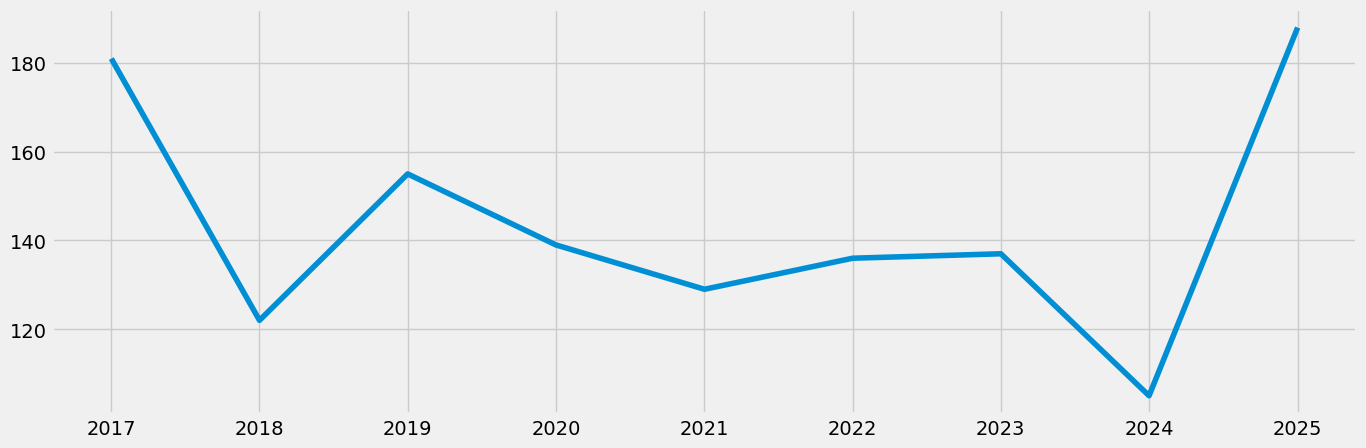

In [122]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [123]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -5.126023
p-value                        0.000012
Number of Lags Used            0.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


#### Now the statistics is smaller than any critical value, therefore the null hypothesis can be rejected. The data is stationary.

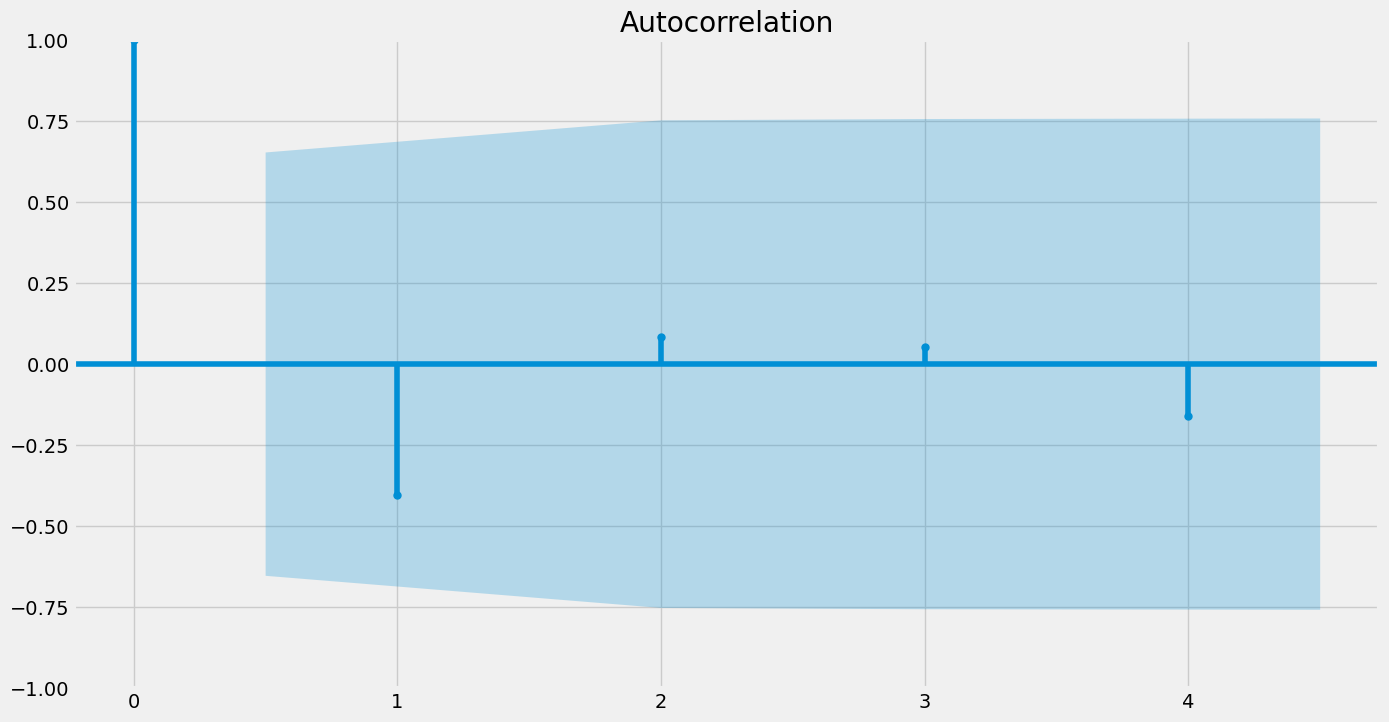

In [124]:
plot_acf(data_diff)
plt.show()

#### The autocorrelation looks also good. There are no lines above the confidence interval, beyond the initial line (=1.0) 